In [1]:
from IPython.display import Image
from collections import defaultdict
import numpy as np
from matplotlib import animation
import matplotlib.pyplot as plt
import random, math

In [2]:
import sys
import os
sys.path.append(os.path.abspath('../'))

## Bandit

- 什么叫多臂老虎机（Multi-Armed Bandit，MAB）
    - 一个拥有 $N$ 根拉杆 （arms）的老虎机，拉动每一根拉杆都对应一个关于奖励的概率分布 $\mathcal R$;
    - 每次拉动其中一根拉杆，就可以从该拉杆对应的概率分布 $\mathcal R$ 中获得一个奖励 $r$（observation，观测值），
        - $r\sim \mathcal R$
    - 序列决策问题（sequence decision making）：我们在各根拉杆奖励的概率分布 $\mathcal R$ 分布未知的情况下，从头开始尝试，目标在操作 $T$ 次拉杆后获得尽可能高的累积奖励（cumulative rewards）
- 仍属于 value-based methods
    - 状态/action：价值的度量；
- 多臂老虎机是后续学习 MCTS 的基础；
    - 蕴含了很多搜索的思想；
    - double EE：exploration & exploition；
        - epsilon greedy；
        - exploration：探索拉杆的获奖概率；
        - exploition：根据经验选择获奖最多的拉杆；
        - 可以大致理解为比如一个学习的过程，探索是找到相关topic更多相关的材料 books/papers/blogs, 利用就是深入的读这些内容；
- representation 表示上；
    - state：或者说 state space 其实为1，全局只有一个，也就无所谓状态的好坏，我们用 Dummy state 0 来表示，主要是对齐 qfunction/Qtable；
        - 因为全局只有1个状态，也就无所谓转移 $P_a(s'|s)$
    - action：index of arms，有多少个臂，就意味着有多大的动作空间；

In [3]:
class MultiArmedBandit:

    """ Select an action for this state given from a list given a Q-function """

    def select(self, state, actions, qfunction):
        abstract

    """ Reset a multi-armed bandit to its initial configuration """

    def reset(self):
        self.__init__()

In [10]:
# from q_table
def get_max_q(qtable, state, actions):
    max_q = float('-inf')
    # 也就是 a
    arg_max_q = None
    for a in actions:
        q = qtable[(state, a)]
        if max_q < q:
            max_q = q
            arg_max_q = a
    return arg_max_q, max_q

###  $\epsilon$-greedy

- $\epsilon\in[0,1]$，balancing exploration and exploitation
    - With probability $\epsilon$ we choose a random arm with uniform probability.
    - With probability $1-\epsilon$ we choose the arm with the maximum Q value: $\arg\max_aQ(a)$. If there is a tie between multiple actions with the larget Q-value, break the tie randomly（随机打破平局）.

In [16]:
class EpsilonGreedy(MultiArmedBandit):
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon

    def reset(self):
        pass

    def select(self, state, actions, qtable):
        # epsilon greedy
        if random.random() < self.epsilon:
            return random.choice(actions)
        (arg_max_q, _) = get_max_q(qtable, state, actions)
        return arg_max_q

## 问题定义

In [40]:
Image(url='./imgs/mab_algo.png', width=600)

- $X_{a,k}$: $k$ 时刻，选择动作 $a$（某一个 arm），拿到的 reward
- $Q(a)\leftarrow Q(a)+\frac{1}{N(a)}\left[X_{a,k}-Q(a)\right]$，这样一种增量更新
- 这个 algo 是用来计算 Q function/table 的；

$$
\begin{split}
Q_k&=\frac1k\sum_{i=1}^kr_i\\
&=\frac1k\left(r_{k}+\sum_{i=1}^{k-1}r_i\right)\\
&=\frac1k\left(r_k+(k-1)Q_{k-1}\right)\\
&=\frac1k\left(r_k+kQ_{k-1}-Q_{k-1}\right)\\
&=Q_{k-1}+\frac1k\left(r_k-Q_{k-1}\right)
\end{split}
$$

## 算法与求解

In [23]:
def run_bandit(bandit, episodes=200, episode_length=500):
    
    # 5 arms or 5 actions
    actions = [0, 1, 2, 3, 4]
    rewards = []
    dummy_state = 0
    
    for _ in range(episodes):
        bandit.reset()
        # 各个臂上 reward = 5 的 p，1-p 时 reward = 0
        probabilities = [0.1, 0.3, 0.7, 0.2, 0.1]
        N_dict = defaultdict(int)
        # (state, action)
        Q_table = defaultdict(lambda: 0.)
        episode_rewards = []
        for step in range(episode_length):
            action = bandit.select(dummy_state, actions, Q_table)
            reward = 0
            if random.random() < probabilities[action]:
                reward = 5
            episode_rewards.append(reward)
            N_dict[action] += 1
            Q_table[(dummy_state, action)] += (reward - Q_table[(dummy_state, action)]) / N_dict[action]
        rewards += [episode_rewards]
    return rewards

In [45]:
epsilon000 = run_bandit(EpsilonGreedy(epsilon=0.00))
epsilon005 = run_bandit(EpsilonGreedy(epsilon=0.05))
epsilon01 = run_bandit(EpsilonGreedy(epsilon=0.1))
epsilon02 = run_bandit(EpsilonGreedy(epsilon=0.2))
epsilon05 = run_bandit(EpsilonGreedy(epsilon=0.5))
epsilon08 = run_bandit(EpsilonGreedy(epsilon=0.8))

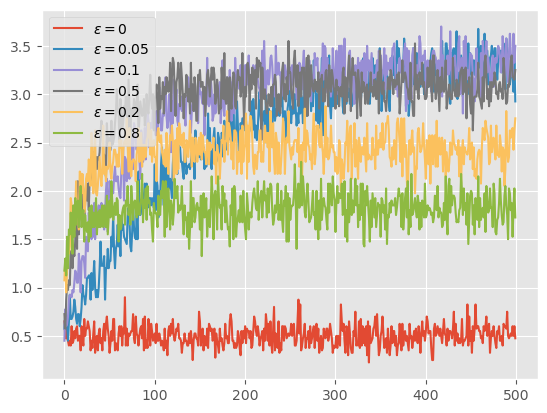

In [46]:
plt.style.use('ggplot')
plt.plot(np.asarray(epsilon000).mean(axis=0))
plt.plot(np.asarray(epsilon005).mean(axis=0))
plt.plot(np.asarray(epsilon01).mean(axis=0))
plt.plot(np.asarray(epsilon02).mean(axis=0))
plt.plot(np.asarray(epsilon05).mean(axis=0))
plt.plot(np.asarray(epsilon08).mean(axis=0))
plt.legend(['$\epsilon=0$', '$\epsilon=0.05$', '$\epsilon=0.1$', '$\epsilon=0.5$', 
            '$\epsilon=0.2$', '$\epsilon=0.8$'])

- higher epsilon => have a lower reward over time，除了 $\epsilon=0$
    -  Higher values mean more exploration, so the bandit spends more time exploring less valuable actions, even after it has a good estimate of the value of actions. 

## $\epsilon$-greedy 的一些变体

### Epsilon-decreasing strategy

$$
\epsilon:=\epsilon\times \alpha
$$

In [ ]:
class EpsilonDecreasing(MultiArmedBandit):
    def __init__(self, epsilon=0.2, alpha=0.999):
        self.epsilon_greedy_bandit = EpsilonGreedy(epsilon)
        self.initial_epsilon = epsilon
        self.alpha = alpha

    def reset(self):
        self.epsilon_greedy_bandit = EpsilonGreedy(self.initial_epsilon)

    def select(self, state, actions, qfunction):
        result = self.epsilon_greedy_bandit.select(state, actions, qfunction)
        self.epsilon_greedy_bandit.epsilon *= self.alpha
        return result

### Softmax strategy

$$
\frac{e^{Q(a)/\tau}}{\sum_{b=1}^{N} e^{Q(b)/\tau}}
$$

## Upper Confidence Bounds (UCB1)

- 一台双臂老虎机，其中第一根拉杆只被拉过1次（$N_1=1$），得到的奖励为 0；而第二根拉杆被拉动过很多次，我们对它的奖励分布 $\mathcal R$ 已经有了大致的把握；
- 基于不确定性（第一根拉杆只被拉过一次，不确定性很高），拉第一根拉杆，不确定越高，越有探索的价值；
    - $U(a)$ 就是用来刻画 arm 的不确定性；
    - $U(a)$ 会随着被尝试次数 $N(a)$ 的增加而减少；

$$
\begin{split}
a_t^{UCB}&=\text{argmax}_{a}\left(Q(a) + U(a)\right)\\
&=\text{argmax}_{a}\left(Q(a) + \sqrt{\frac{2 \ln t}{N(a)}}\right)
\end{split}
$$

- to select the next action 
- $t$ the number of rounds so far
- 上置信界，跟 ELBO 一样也是一个 bounds；
    - UCB 用来tradeoff Exploration & Exploitation
- EE：
    - The left–hand side encourages exploitation: the Q-value is high for actions that have had a high reward.
    - The right–hand side encourages exploration: it is high for actions that have been explored less – that is, when $N(a)$ relative to other actions.
- 如果左侧表示 Exploit，右侧表示 Exploration，其实这个公式并不是一个 weighted 的版本（没有参数调控两个分量）；
    -  the Q-function ($Q(s)=Q(s, a)$), which gives us the average return on each action $a$, 用它来逼近真实的（也未知的）Q-function，即为 $Q^*$
    - 对于所有的 $b\neq a$
    
    $$
    Q(b)+\sqrt\frac{2\ln t}{N(b)}\leq Q^*(a)
    $$

In [4]:
class UpperConfidenceBounds(MultiArmedBandit):
    def __init__(self):
        self.T = 0
        self.N_dict = dict()
    
    def select(self, state, actions, qfunction):
        # First execute each action one time
        for a in actions:
            if a not in self.N_dict.keys():
                self.N_dict[a] = 1
                self.T += 1
                return a
        max_actions = []
        max_value = float("-inf")
        for a in actions:
            v = qfunction.get_q_value((state, a)) + math.sqrt(2*np.log(self.T)/self.N_dict[a])
            if v > max_value:
                max_actions = a
                max_value = v
            elif v == max_value:
                max_actions.append(a)
        result = random.choice(max_actions)
        self.N_dict[result] +=1
        self.T += 1
        return result